<a href="https://colab.research.google.com/github/karlriis/trajectory-forecasting/blob/main/Edinburgh_NN_over_all_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/crowdbotp/OpenTraj.git

Cloning into 'OpenTraj'...
remote: Enumerating objects: 17725, done.
remote: Counting objects: 100% (1526/1526), done.
remote: Compressing objects: 100% (826/826), done.
remote: Total 17725 (delta 807), reused 1355 (delta 683), pack-reused 16199
Receiving objects: 100% (17725/17725), 390.77 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (1245/1245), done.
Checking out files: 100% (15796/15796), done.


In [2]:
! pip install pykalman

     |████████████████████████████████| 228 kB 4.0 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=be3a3d6fab0081c4ca364259acad5a9a72c84572abacdb32d236c5b2b682e58d
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [3]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

In [4]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=4)

/content/OpenTraj/opentraj/toolkit/loaders/loader_edinburgh.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(file, sep="\n|=", header=None,index_col=None)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|██████████| 2342/2342 [06:02<00:00,  6.46it/s]


Warning! too big dt in [Edinburgh]
finish


In [206]:
data = traj_dataset.data
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

In [207]:
# 'Normalize' the data so that all trajectories will begin at x=0, y=0
for agent_id in agent_ids:
    first_x = data[data.agent_id == agent_id]['pos_x'].iloc[0]
    first_y = data[data.agent_id == agent_id]['pos_y'].iloc[0]
    
    data.loc[data.agent_id == agent_id, 'pos_x'] = data[data.agent_id == agent_id]['pos_x'] - first_x
    data.loc[data.agent_id == agent_id, 'pos_y'] = data[data.agent_id == agent_id]['pos_y'] - first_y

In [208]:
# Select the useful columns from the dataset
data = data[['index', 'agent_id', 'pos_x', 'pos_y']]

In [209]:
from sklearn.model_selection import train_test_split
train_agent_ids, test_agent_ids = train_test_split(agent_ids, test_size=0.2)

### Helper functions

In [210]:
def create_dataset(data, agent_ids):
    dataX, dataY = [], []
    for agent_id in agent_ids:
        x = data[data['agent_id'] == agent_id].iloc[:5][['pos_x', 'pos_y']]
        y = data[data['agent_id'] == agent_id].iloc[5][['pos_x', 'pos_y']]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

In [211]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [213]:
from keras.models import Model
from keras.layers import *    

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(16, activation='linear')(x)
x = Dense(8, activation='linear')(x)

out1 = Dense(1, activation='linear')(x)    
out2 = Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
sep_y_train_data = np.hsplit(train[1], 2) # separate the y data into pieces to only provide 1 point as NN output
model.fit(train[0], [sep_y_train_data[0], sep_y_train_data[1]], epochs=400, batch_size=1, verbose=2)

Epoch 1/400
1577/1577 - 3s - loss: 0.2002 - dense_34_loss: 0.0886 - dense_35_loss: 0.1117 - 3s/epoch - 2ms/step
Epoch 2/400
1577/1577 - 3s - loss: 0.2024 - dense_34_loss: 0.0897 - dense_35_loss: 0.1127 - 3s/epoch - 2ms/step
Epoch 3/400
1577/1577 - 3s - loss: 0.2059 - dense_34_loss: 0.0941 - dense_35_loss: 0.1119 - 3s/epoch - 2ms/step
Epoch 4/400
1577/1577 - 3s - loss: 0.2004 - dense_34_loss: 0.0884 - dense_35_loss: 0.1120 - 3s/epoch - 2ms/step
Epoch 5/400
1577/1577 - 3s - loss: 0.2015 - dense_34_loss: 0.0904 - dense_35_loss: 0.1111 - 3s/epoch - 2ms/step
Epoch 6/400
1577/1577 - 4s - loss: 0.2064 - dense_34_loss: 0.0947 - dense_35_loss: 0.1118 - 4s/epoch - 2ms/step
Epoch 7/400


In [215]:

trainScore = model.evaluate(train[0], [sep_y_train_data[0], sep_y_train_data[1]], verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))

sep_y_test_data = np.hsplit(test[1], 2)
testScore = model.evaluate(test[0], [sep_y_test_data[0], sep_y_test_data[1]], verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))

Train Score: 0.19 MSE (0.44 RMSE)
Test Score: 0.16 MSE (0.40 RMSE)


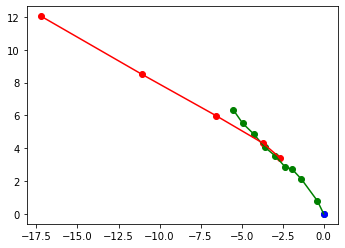

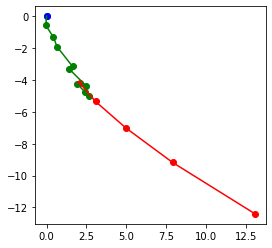

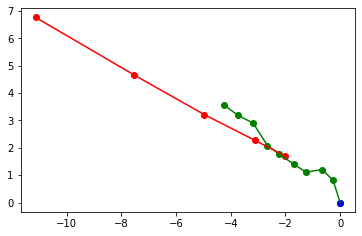

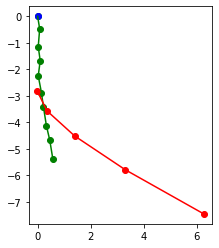

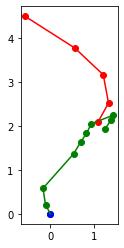

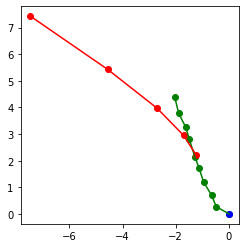

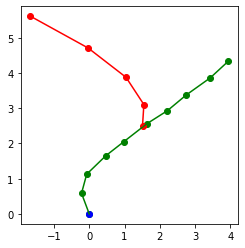

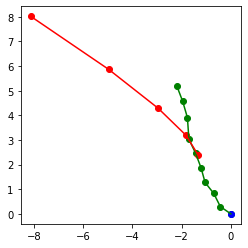

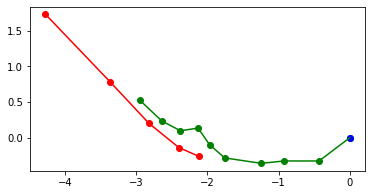

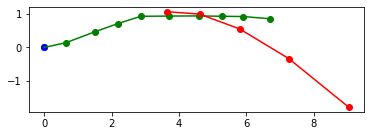

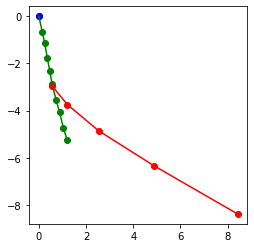

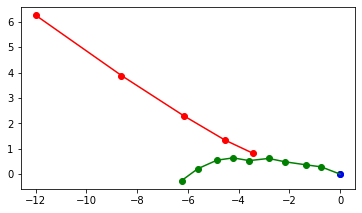

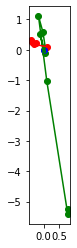

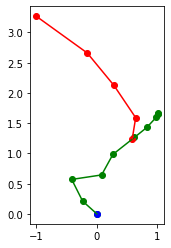

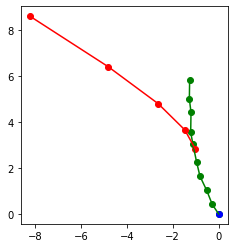

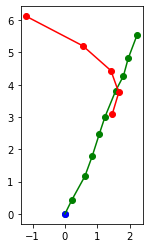

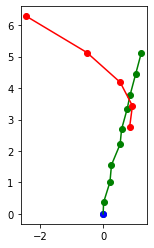

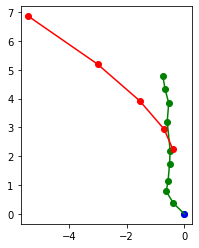

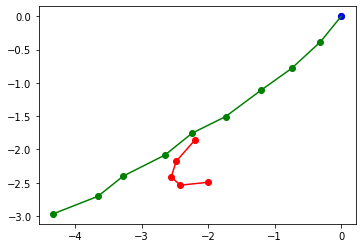

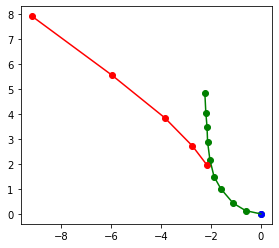

In [216]:
for agent_id in test_agent_ids[:20]:
  seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
  seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
  unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
  unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

  rolling_x = np.array(seen_x)
  rolling_y = np.array(seen_y)
  for i in range(5):
    seen_coordinates = np.column_stack((rolling_x, rolling_y))
    pred_x, pred_y = model.predict(np.array([seen_coordinates]))

    rolling_x = np.append(rolling_x[1:], [pred_x[0]])
    rolling_y = np.append(rolling_y[1:], [pred_y[0]])
  
  # plot data
  plt.axes().set_aspect('equal')

  plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
  plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

  plt.plot(rolling_x, rolling_y, color='r')
  plt.scatter(rolling_x, rolling_y, color='r')

  plt.scatter(seen_x[0], seen_y[0], color='b')

  plt.show()

In [179]:
abc = np.array([[1,2],[1,2],[1,2],[1,2],[1,2]], dtype='float32')
abc_pred = model.predict(np.array([abc]))
print(abc_pred)

[array([[-1.8019186]], dtype=float32), array([[1.0680474]], dtype=float32)]


In [221]:
test_preds = np.array(model.predict(test[0]))

In [225]:
np.save('NN_test_preds.npy', test_preds)